<a href="https://colab.research.google.com/github/bosunKwak/BigData/blob/main/Transformer_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# numpy
import numpy as np 
# pytorch module
import torch
import torch.nn as nn # torch.nn : architecture를 구성할때 필요한 layer
import torch.nn.functional as F # softmax 계산시 사용

import math, copy, time
# graph
import matplotlib.pyplot as plt
%matplotlib inline

# 1. EncoderDecoder and Generator models
- 최상위 class

<img width="381" alt="스크린샷 2022-06-09 오후 11 12 57" src="https://user-images.githubusercontent.com/87002218/172868199-3593494b-a543-4f85-9e51-d559f8076f4a.png">


In [ ]:
class EncoderDecoder(nn.Module): #Transformer
    '''
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    '''
    # Encoder, Decoder, Generator, src_embed(Encoder에 들어가는 input부분의 embedding layer), tgt_embed(decoder로 들어가는 input부분의 embedding layer)
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    
    '''
    data관점에서 보면
      input -> src_embed-> (data, masking data) -> encoder -> (1)
      target input -> tgt_embed -> (data, masking data) -> (2)
      (1) & (2) -> decoder -> generator -> output
    '''
    def forward(self, src, tgt, src_mask, tgt_mask): # src(input), tgt(target input)
        memory = self.encode(src, src_mask) 
        return self.decode(memory, src_mask, tgt, tgt_mask)  # memory: context정보 

    ''' 풀어쓰면 아래 코드와 같음
    def forward():
        x= self.src_embed(src) 
        x= self.encoder(x, src_mask)
        y = self.tgt_embed(tgt)
        y = self.decoder(x,src_mask,y,tgt_mask)
        return self.generator(y)
    '''

In [ ]:
# layer를 N개 복사하는 함수 
def clones(module, N):
    "Produce N identical layers." 
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

# Encoder and Decoder
- 6개의 sublayer가 있음
- Decoder의 입력값:  encoder의 최종결과값, encoder에서 주는 mask 정보, decoder target, target의 mask 정보

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N): 
        super(Encoder, self).__init__()
        self.layers = clones(layer, N) #layer를 n번 복사하여 layer list  (n=6)
        self.norm = LayerNorm(layer.size) # encoder에서 나온값을 normalization 해 줌 -> 데이터를 고르게 함

    ''' Encoder관점에서 보면
    x, mask -> encoder -> y,mask
    sublayer 6개 통과 
    '''    
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers: #layers: layer가 n개
            x = layer(x, mask) # layer에 x,mask값이 들어옴 
        return self.norm(x) #normalization한 값을 반환

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### LayerNormalization
- batch normalize와는 다름
- dimension안에서의 normalization(차원의 값을 맞추어주는 역할)

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features_size, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.scale = nn.Parameter(torch.ones(features_size))
        self.shift = nn.Parameter(torch.zeros(features_size))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdims=True)
        std = x.std(-1, keepdims=True)
        return (x - mean) * self.scale / (std + self.eps) + self.shift

### SubLayerConnection
- x -> Normalization (=LayerNorm(x)) -> Sublayer -> x+sublayer(LayerNorm(x))
- sublayer에 가기전에 x를 normalization을 해주는 것!! 
- 일부를 random하게 dropout 

- SubLayerConnection : Normalization + sublayer

In [ ]:
class SubLayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SubLayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

# EncoderLayer
- self attention layer
- Add and Normalization layer(= SubLayerConnection)
- Feed forward layer
- another Add and Normalization layer

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__() # 초기화
        self.size = size
        # attentino layer
        self.self_attn = self_attn
        # feed forward layer
        self.feed_forward = feed_forward
        #sublayer 2개 - add and normalization 
        self.sublayers = clones(SubLayerConnection(size, dropout), 2) # dropout : 얼마나 누락시킬 것인지에 대한 비율
        

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # x값 3개, mask 값 들어감 
        attn_func = lambda x: self.self_attn(x, x, x, mask)
        x = self.sublayers[0](x, attn_func) # sublayer 2개를 생성했기때문에 [0]과 [1] 
        return self.sublayers[1](x, self.feed_forward)

# Attention
- Q, K, V 필요
- Query : 찾아야할 값 
- Key , Value 로 된 DB
- Q&K -> MatMul -> Scale(root) -> SoftMax -> (1)
- (1)&V -> MatMul -> 결과   


In [ ]:
# dropout 은 성능향상을 위해 option으로 넣음 
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    '''N x a x b 를 matrix shape 라 할때, 
      query.size(-1) : b를 의미, 즉 차원의 크기 
      논문에서는 dimension을 512로 맞춰주고있음 
    '''
    d_k = query.size(-1) # 차원의 크기 d_k
    # key.transpose(-2, -1) : a와 b의 자리를 바꿈 
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k) 
  
    # encoder: 없음 decoder: 있음 
    if mask is not None: #mask가 있으면, score에 mask을 매우 작은 값으로 바꿔줌 
        scores.masked_fill_(mask == 0, -1e9)
    
    # torch.nn.function 을 사용 
    prob_scores = F.softmax(scores, dim = -1)
    
    # score에서 일부를 누락시켜 확률 형태의 score값 만듦
    
    if dropout is not None:
        prob_scores = dropout(prob_scores)
    
    # (1)&V matmul
    attn_scores = torch.matmul(prob_scores, value)

    return attn_scores, prob_scores

# MultiHeadAttention
- Query, Key, Value 을 각각 Linear -> Scaled Dot-Product Attention -> Concat -> Linear
- scaled dot-product attention 이 h개 쌓여있음 
- x data의 shape 변형이 필요함

Note that for each attention head, we have an input with shape _something_ like:  
몇개의 sentence, 단어의 개수, 단어가 몇 차원으로 embedding했는지 dimension을 나타냄 = 512/8) (h=8)
```
(batch size, words in each input, 64)
```

Now that we have multiple heads, we want the input tensor to have _something_ like: (attention heads가 8개) 
```
(batch size, number of attention heads, words in each input, 64)
```

(3,w,512) -> (3,w,4*128) -> (3,w,4,128) -> (3,4,w,128)   
<Concatenate 과정>  
-> (3,2,4,128) ->(3,2,4*128) -> (3,w,512)


In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__() # 초기화 
        assert d_model % h == 0 # 중요! h는 attention head (논문은 8개)
        # We assume d_v always equals d_k
        self.d_k = d_model // h 
        self.h = h

        '''
         Query, Key, Value 을 각각 Linear (총 3번)
         -> Scaled Dot-Product Attention 
         -> Concat 
         -> Linear
        ''' # linear layer mapping 총 4번
        self.linears = clones(nn.Linear(d_model, d_model), 4) # d_model : 초창기에 설정한 model 
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
        # Masked 가 있기때문에 mask가 있음
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) #1번에 해당하는 위치의 차원을 늘려줌 
        nbatches = query.size(0) # 0 : batch_size
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # for 문을 돌며 list 생성 
        # zip 함수 : 하나씩 꺼내어 l과 x에 넣어줌 (query -> linear layer를 통해 차원을 바꿔주는 것)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        # 8개의 attention에 대한 결과 
        # attn_scores와 prob_scores(연관관계에 대한 확률)가 각각 x, self.attn으로 들어감 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

# DecoderLayer
- attention layer 2
  - masked multi-head attention (mask된 정보 이용)
  - multi-head attention(encoder & decoder)
- feed-forward 1
- sublayerconnection 3

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    # attention layer : self_attn, src_attn
    # self_attn : masked multi-head attention
    # src_attn : multi-head attention 
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size # size : sublayerconnection 에서 단어 임베딩의 크기 (논문에서 512)
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropout), 3)
 
    '''
    x : decoder로 들어오는 입력값
    tgt_mask : decoder로 들어오는 mask 정보
    memory: encoder에서 들어오는 memory
    src_mask : encoder에서 들어오는 mask 정보 
    '''
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        # 최초 입력값 x와 decoder로 들어오는 입력값이기 때문에 tgt_mask도 필요함 
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask)) 
        # Add&Norm 을 지난 값 x(query), encoder에서 들어오는 m값 2개(key, value)가 sublayer로 들어감 
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        # 위 결과값이 feedforward layer을 거쳐 결과값 
        return self.sublayer[2](x, self.feed_forward)

## mask
- 단어를 가려주는 것
- RNN 의 recurrent하는 과정을 transformer에서는 mask과정을 사용함으로써 표현
- matrix 형태로 구성해서 한번에 처리 가능 
- 보이는 정보를 true, 가리는 정보를 false


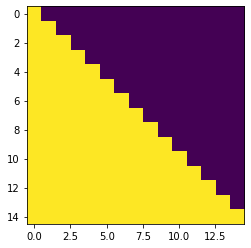

In [ ]:
def subsequent_mask(size): # size : 단어의 개수 
    "Mask out subsequent positions."
    attn_shape = (1, size, size) # 1: batch를 위해 차원을 늘려줌 (size x size)의 틀을 만들어줌 
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # np.triu : 남색으로 보이는 부분을 1로 채워주고, 노란색 부분을 0으로 지정
    return torch.from_numpy(subsequent_mask) == 0 #(0인것을 참으로 함 - 노란색이 true)
plt.imshow(subsequent_mask(15)[0])

# Generator
decoder에서 나온 결과 -> linear (공간 차원으로 바꿔줌, vocab_size로 늘려줌) -> softmax(확률값으로 변환해줌)


In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab) #d_model : 임베딩한 차원 vocab : 결과값

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1) # dim=-1 : softmax함수를 임베딩 차원으로 계산하겠다는 의미

# FeedForward
- Encoder, Decoder에서 사용
- 512dim -> 2048 dim -> 512 dim
- ReLU function을 사용
- 0보다 작으면 0 0보다 크면 linear 함수로 증가 

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff) # 512->2048
        self.w_2 = nn.Linear(d_ff, d_model) # 2048-> 512 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))) # 1 layer -> relu -> dropout-> 2 layer

# Positional Encoding
- 위치에 대한 정보를 만들어줌
- RNN 구조에는 sequence가 진행되는 과정에서 위치에 대한 정보가 자연스럽게 반영되는데, RNN 구조를 사용하지 않으므로 Position encoding이라는 vector를 만들어서 위치정보를 넣어줌
- Input -> embedding -> positional encoding -> embedding with time signal
- sin함수 : 2i(짝수 위치) , cos 함수 : 2i+1(홀수 위치)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_embedding, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout) 
        
        # torch.zeros : 0으로 채워진 tensor를 만듦 
        # - max_len : 단어의 개수(position의 최대 값), dim_embedding: dimension의 크기 
        positional_encodings = torch.zeros(max_len, dim_embedding)
        # positions : 0으로 된 값을 max_len의 크기만큼 만든 배열 (단어의 postion 값)
        # 열벡터 값으로 만듦 
        positions = torch.arange(0, max_len).unsqueeze(1).float()
        
        # calculate the arguments for sin and cos functions
        scale = -(math.log(10000) / dim_embedding) # -log(10^4)/d
        arguments = torch.arange(0, dim_embedding, 2).float() * scale 
        arguments = torch.exp(arguments) 
        arguments = positions * arguments # sin/cos 함수 넣기 전의 값
        
        # define the encodings here
        positional_encodings[:, 0::2] = torch.sin(arguments) # 짝수
        positional_encodings[:, 1::2] = torch.cos(arguments) # 홀수 
        
        positional_encodings = positional_encodings.unsqueeze(0) # 가장 앞부분의 1 차원을 늘려줌 
        self.register_buffer('positional_encodings', positional_encodings) 
        # register_buffer : position embedding 값은 학습을 하는 값이 아니기 때문에 버퍼를 통해 저장

    #
    def forward(self, x):
        pos_enc = self.positional_encodings[:, :x.size(1)] # x.size(1) : 문장에서의 단어 개수 
        pos_enc.requires_grad_(False) #gradient를 구하지 않음 == 학습을 하지 않겠다 
        x  = x + pos_enc
        return self.dropout(x)

# Embeddings
- 단어를 모아 vocabulary 를 만들고 vocab을 갖고 분산된 표현으로 단어를 바꾸어줌 

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab, dim_embedding):
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab, dim_embedding) # (vocab set, 몇 차원으로 표현할지)
        self.dim_embedding = dim_embedding
        
    def forward(self, x):
        # embedding is multiplied by scale to make the positional encoding relatively smaller
        # See: https://towardsdatascience.com/how-to-code-the-transformer-in-pytorch-24db27c8f9ec
        return self.embed(x) * math.sqrt(self.dim_embedding) # scale
    

# Make Model 

In [ ]:
def make_model(src_vocab, tgt_vocab, 
               num_enc_dec=6, dim_model=512, dim_feedfwd=2048, attn_heads=8, dropout=0.1):
    # prepare the embeddings for encoder and decoder stacks
    position_embeddings = PositionalEncoding(dim_model, dropout)
    src_embed = nn.Sequential(Embedding(src_vocab, dim_model), copy.deepcopy(position_embeddings))
    tgt_embed = nn.Sequential(Embedding(tgt_vocab, dim_model), copy.deepcopy(position_embeddings))
    
    # prepare reusable layers. we will copy.deepcopy them whenever needed
    attn_layer = MultiHeadedAttention(attn_heads, dim_model)
    feed_fwd_layer = PositionwiseFeedForward(dim_model, dim_feedfwd, dropout)
    c = copy.deepcopy
    
    # prepare the encoder stack
    encoder_layer = EncoderLayer(dim_model, c(attn_layer), c(feed_fwd_layer), dropout)
    encoder = Encoder(encoder_layer, num_enc_dec)
    
    # prepare the decoder stack
    decoder_layer = DecoderLayer(dim_model, c(attn_layer), c(attn_layer), c(feed_fwd_layer), dropout)
    decoder = Decoder(decoder_layer, num_enc_dec)
    
    # prepare the generator
    generator = Generator(dim_model, tgt_vocab)
    
    # create the model
    model = EncoderDecoder(encoder, decoder, src_embed, tgt_embed, generator)
    
    # Initialize parameters using Xavier initialization
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
    return model